In [1]:
import numpy as np

In [2]:
import os

In [3]:
import ntpath

In [4]:
import math as mt

In [5]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as col

In [6]:
from matplotlib.ticker import FormatStrFormatter

In [7]:
from power_spec import power_spec as ps

In [8]:
from cpw_resonator import cpw_resonator as cpw

In [9]:
from qkit.analysis import dat_reader as dat

In [10]:
from qkit.analysis.resonator import Resonator as Resonator

In [11]:
from qkit.analysis.circle_fit.circuit import reflection_singleport as rf_p

In [12]:
from qkit.analysis.circle_fit.utilities import plotting, save_load, Watt2dBm, dBm2Watt

In [13]:
from qkit.storage import hdf_lib

In [14]:
from tvregdiff import TVRegDiff as tv

In [15]:
from scipy.ndimage import gaussian_filter1d
from scipy.ndimage.filters import median_filter

In [16]:
import random

In [17]:
font = {'weight' : 'normal', 'size' : 22}
plt.rc('font', **font)
labelsize=28

In [18]:
%matplotlib inline

In [19]:
import scipy.special as ss
import scipy.constants as sc


phi_0 = sc.physical_constants['magn. flux quantum'][0]
c = sc.physical_constants['speed of light in vacuum'][0]   
h = sc.h
hbar = sc.h/(2*np.pi)
e = sc.e 
R_k = h/e**2

# Mask no.3 

In [20]:
powerpath = "C:/Users/Patrick/Documents/JPA/Mask #3/data/20160407/120624_2D_VNA_tracedata/120624_2D_VNA_tracedata.h5"
#powerpath = "C:/Users/Patrick/Documents/JPA/Mask #3/data/20160407/115511_2D_VNA_tracedata/115511_2D_VNA_tracedata.h5"
#powerpath = "C:/Users/Patrick/Documents/JPA/Mask #3/data/20160407/120624_2D_VNA_tracedata/120624_2D_VNA_tracedata.h5"

In [21]:
data=hdf_lib.Data(path=powerpath)

In [22]:
freq = np.array(data['/entry/data0/frequency'])
amplitude = np.array(data['/entry/data0/amplitude'])
phase =  np.array(data['/entry/data0/phase'])
power = np.array(data['/entry/data0/power (dbm)'])
z_data_raw = amplitude*np.exp(1.j*phase)

In [23]:
power.shape

(10,)

In [24]:
i = 9

In [25]:
cf = rf_p(freq, z_data_raw[i])

In [26]:
#cf.set_theta0(None)

In [27]:
cf.set_Ql(1200)

In [28]:
cf.autofit('overcoupled', ignoreslope = False, refine_res = False, plot = False)

C:\Anaconda2\lib\site-packages\scipy\optimize\minpack.py:427: RuntimeWarning: xtol=0.000000 is too small, no further improvement in the approximate
  solution is possible.
  warnings.warn(errors[info][0], RuntimeWarning)


fr (phase derivation) = 8841531392.0
agebraic r0: 0.00150263289345
iterative r0: 0.00150252389634
zc = (-2.01054559181e-05-3.10274399923e-05j)
calibration: Theta0 0.0480514903782
3.12035230962
phi_0 = -0.0212403439667


In [29]:
cf.fitresults

{'Qc': 1252.9890185723209,
 'Qc_err': 7.9784834522196126,
 'Qi': 23320.789915532601,
 'Qi_err': 3882.9267108286999,
 'Ql': 1189.1005346369536,
 'Ql_err': 2.9438029471772733,
 'chi_square': 0.0013558691838140022,
 'fr': 8841461550.5340118,
 'fr_err': 12701.503703582619,
 'phi_0': -0.021240343966726534,
 'phi_0_err': 0.0032040543237009814,
 'theta0': -3.1607447296471625}

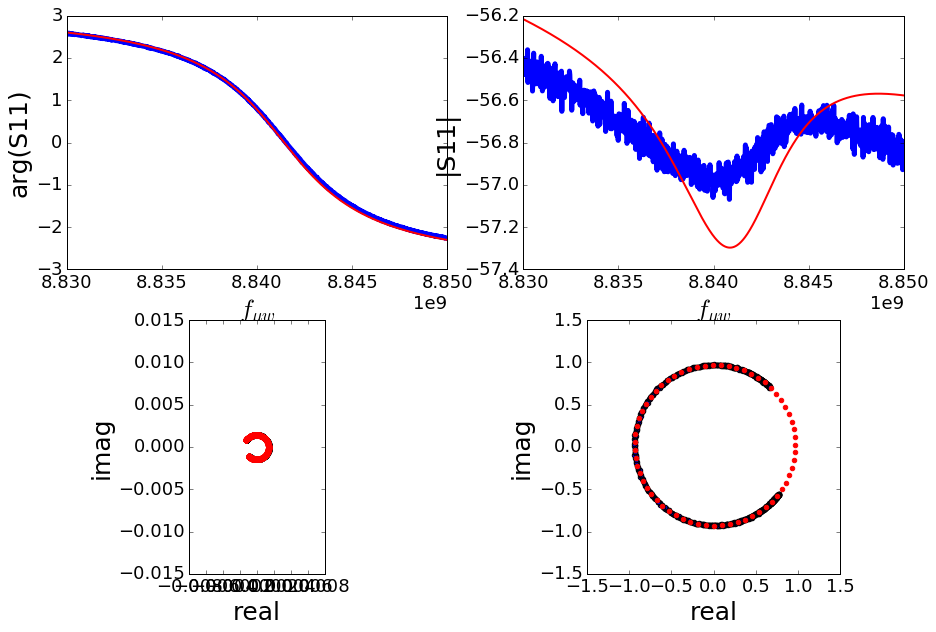

In [30]:
cf.plot_all()

In [31]:
fr, sign = cf._phase_fr_sign(freq, np.unwrap(np.angle(z_data_raw[i])), 3, 20)
theta0 = cf._theta0_start(freq,np.unwrap(np.angle(z_data_raw[i])), fr)
theta0, Ql, fr = cf._phase_fit(freq, z_data_raw[i], 0.1, 1100, fr, 1, overcoupled = True)
  

fr (phase derivation) = 8841831424.0


In [32]:
print Ql, theta0, fr

1204.22293539 0.0889496778422 8841306011.47


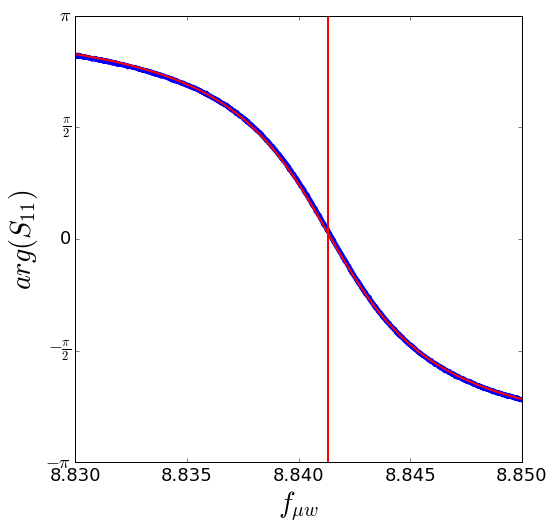

In [33]:
phase = np.unwrap(np.angle(z_data_raw[i]))
phase_fit = cf.phase_fitfunction(freq, theta0, Ql, fr, 0, 1., True)[0]
fig, axes = plt.subplots(figsize = (8,8))
axes.plot(freq/10**9, phase, label = 'data', lw = 5.)
axes.plot(freq/10**9., phase_fit,label = 'phase fit w/ slope', color = 'red', lw = 2.)
axes.axvline(fr/10**9., color = 'red', ls = '-', lw = 2.)
axes.set_xlabel(r'$f_{\mu w}$', fontsize = labelsize)
axes.set_ylabel(r'$arg(S_{11})$', fontsize = labelsize)
axes.set_xlim(8.83,8.85)
plt.setp(axes, yticks=[-np.pi,-np.pi/2, 0., np.pi/2., np.pi], yticklabels = [r'$-\pi$',r'$-\frac{\pi}{2}$', '0',  r'$\frac{\pi}{2}$', r'$\pi$'])
#axes.set_title(str(title), fontsize = 20.)
#axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [34]:
#fig.savefig('phase_lowP_fit_mask3.pdf', dpi = 300, bbox_inches = 'tight')

In [35]:
A1, A2, A3, A4, fr1, Ql1 = cf._fit_skewed_lorentzian(freq, z_data_raw[i], False)

In [36]:
lorentz_sim = cf.Lorentz_function(freq, A1, A2, A3, A4, Ql1, fr1)

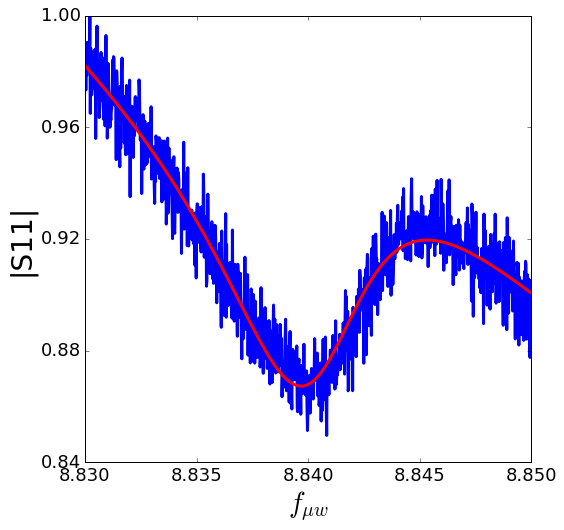

In [37]:
amp = np.absolute(z_data_raw[i])
#amp2 = np.absolute(z_data_raw[9])
fig_amp, axes = plt.subplots(figsize = (8,8))
axes.plot(freq/10**9., amp**2./np.max(amp**2.), label = 'data', lw = 3.)
#axes.plot(freq/10**9., amp2**2./np.max(amp2**2.), label = 'data', lw = 3.)
#axes.plot(freq, 20*np.log10(amp), label = 'data', lw = 2.)
axes.plot(freq/10**9., lorentz_sim/np.max(amp**2.),label = 'skewed lorentzian', color = 'red', lw = 3.)
#axes.axvline(fr/10**9.,color = 'red', ls = '-', lw = 2.)
axes.set_xlabel(r'$f_{\mu w}$', fontsize = labelsize)
axes.set_ylabel(r'|S11|', fontsize = labelsize)
axes.set_xlim(8.83,8.85)
axes.set_yticks([0.84,0.88, 0.92, 0.96, 1.0])
#axes.set_title(str(title), fontsize = 20.)
#axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [38]:
#fig_amp.savefig('amp_lowP_fit_mask3.pdf', dpi = 300, bbox_inches = 'tight')

([<matplotlib.axis.YTick at 0x9bf2830>,
 <a list of 5 Text yticklabel objects>)

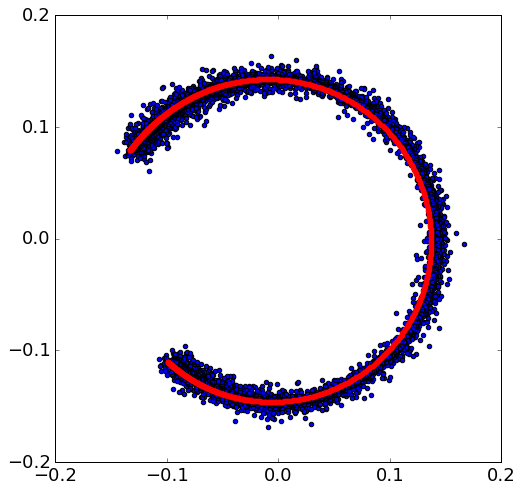

In [39]:
fig_comp = plt.figure(figsize = (8,8))
plt.scatter(z_data_raw.real*100, z_data_raw.imag*100)
plt.scatter(cf.z_data_sim.real*100, cf.z_data_sim.imag*100, color = 'red')
plt.xlim(-0.2, 0.2)
plt.ylim(-0.2, 0.2)
plt.xticks([-0.2,-0.1,0,0.1,0.2])
plt.yticks([-0.2,-0.1,0,0.1,0.2])


In [40]:
#fig_comp.savefig('lowP_circle.pdf', dpi = 100, bbox_inches = 'tight')

(-1.25, 1.25)

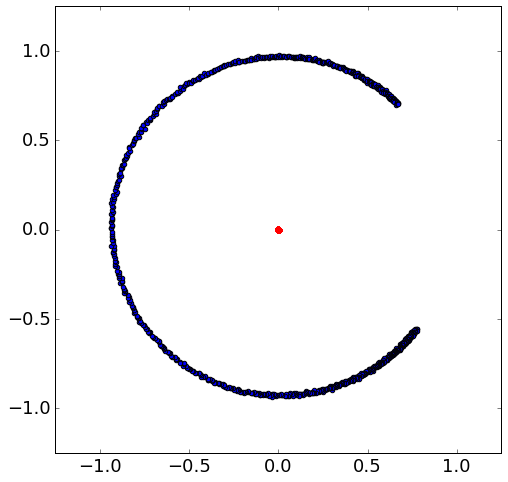

In [41]:
fig_comp = plt.figure(figsize = (8,8))
plt.scatter(cf.z_data.real, cf.z_data.imag)
plt.scatter(cf.z_data_sim.real, cf.z_data_sim.imag, color = 'red')
plt.xlim(-1.25, 1.25)
plt.ylim(-1.25, 1.25)


# power sweep

In [42]:
powerspec = ps(powerpath, gaussfilter = False)

no change - attenuation already: 0 dB


In [43]:
attenuation = 120
powerspec._set_attenuation(attenuation)

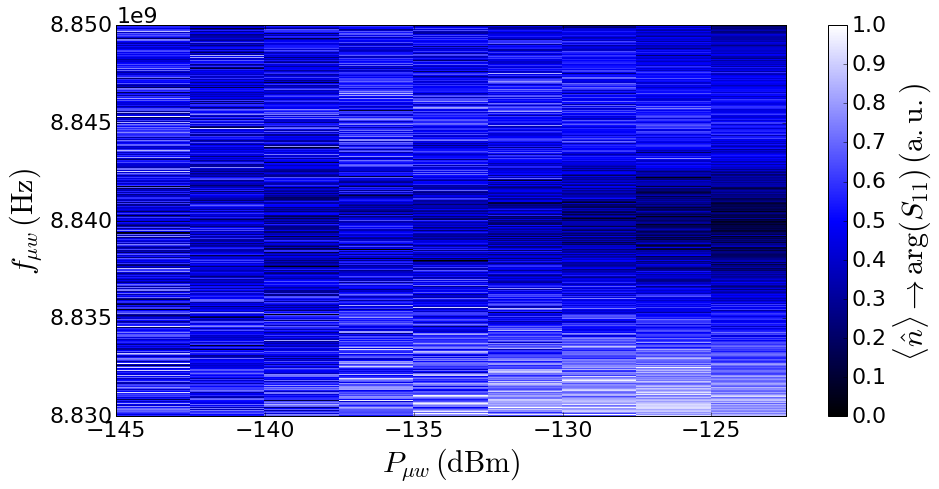

In [44]:
powerspec._plot_amp(norm = True, save = False)

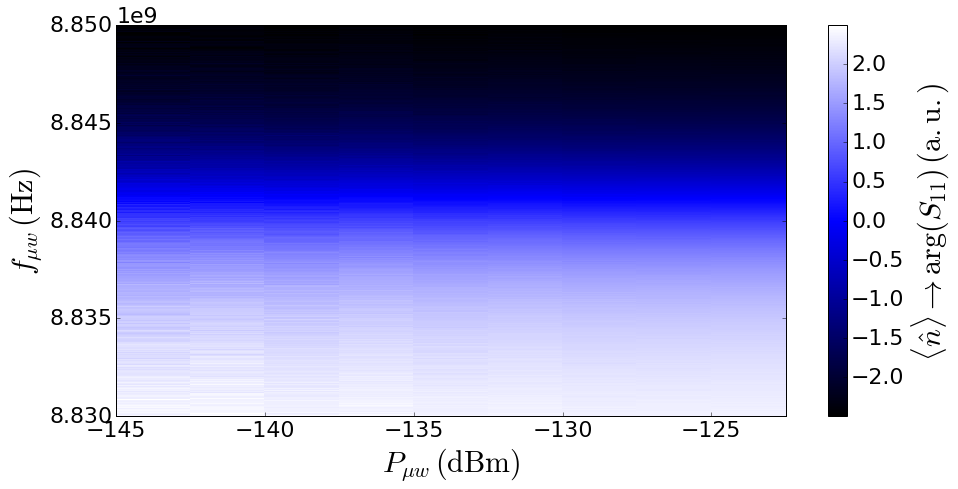

In [45]:
powerspec._plot_phase(norm = True, save = False)

In [46]:
#powerpath = "C:/Users/Patrick/Documents/JPA/Mask #3/data/20160407/120624_2D_VNA_tracedata/120624_2D_VNA_tracedata.h5"
powerpath2 = "C:/Users/Patrick/Documents/JPA/Mask #3/data/20160407/115511_2D_VNA_tracedata/115511_2D_VNA_tracedata.h5"
#powerpath = "C:/Users/Patrick/Documents/JPA/Mask #3/data/20160407/120624_2D_VNA_tracedata/120624_2D_VNA_tracedata.h5"

In [47]:
_data=hdf_lib.Data(path=powerpath2)

In [48]:
_freq = np.array(_data['/entry/data0/frequency'])
_amplitude = np.array(_data['/entry/data0/amplitude'])
_phase =  np.array(_data['/entry/data0/phase'])
_power = np.array(_data['/entry/data0/power (dbm)'])
_z_data_raw = _amplitude*np.exp(1.j*_phase)

In [49]:
powerspec2 = ps(powerpath2, gaussfilter = False)
attenuation = 120
powerspec2._set_attenuation(attenuation)

no change - attenuation already: 0 dB


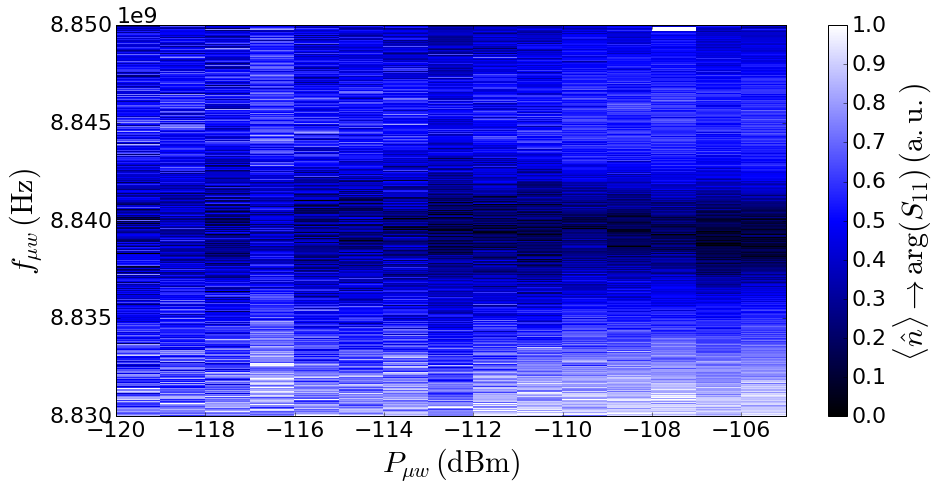

In [50]:
powerspec2._plot_amp(norm = True, save = True)

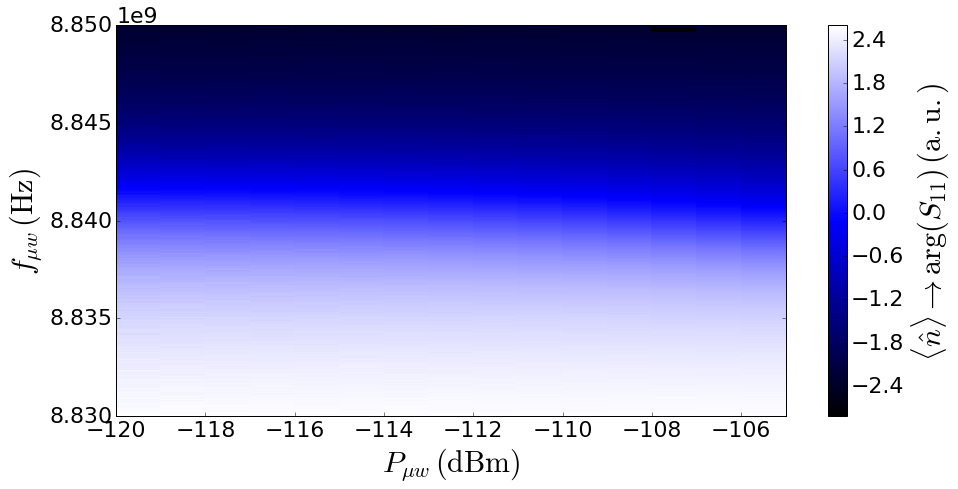

In [51]:
powerspec2._plot_phase(norm = False, save = True)

In [52]:
i = 0
_cf = rf_p(_freq, _z_data_raw[i])

In [53]:
_fr, _sign = _cf._phase_fr_sign(_freq, np.unwrap(np.angle(_z_data_raw[i])), 3, 20)
_theta0 = _cf._theta0_start(_freq,np.unwrap(np.angle(_z_data_raw[i])), _fr)
_theta0, _Ql, _fr = _cf._phase_fit(_freq, _z_data_raw[i], 0, 1000, _fr, 1, overcoupled = True)
  

fr (phase derivation) = 8841831424.0


In [54]:
_z_data_raw.shape

(16, 1000)

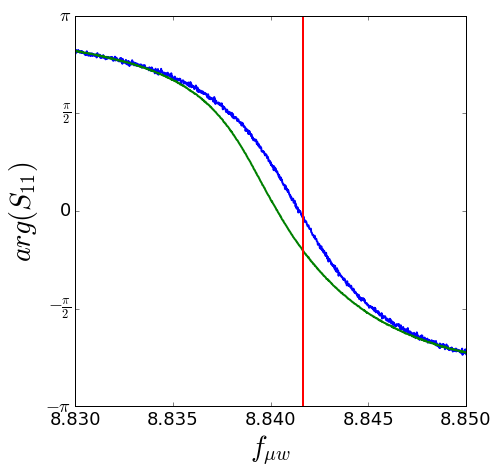

In [55]:
_phase = np.unwrap(np.angle(_z_data_raw[i]))
_phase2 = np.unwrap(np.angle(_z_data_raw[15]))
_phase_fit = _cf.phase_fitfunction(_freq, _theta0, _Ql, _fr, 0, 1., True )[0]
fig, axes = plt.subplots(figsize = (7,7))
axes.plot(_freq/10**9, _phase, label = 'data', lw = 2.)
axes.plot(_freq/10**9, _phase2, label = 'data', lw = 2.)
#axes.plot(_freq/10**9., _phase_fit,label = 'phase fit w/ slope', color = 'red', lw = 2.)
axes.axvline(_fr/10**9., color = 'red', ls = '-', lw = 2.)
axes.set_xlabel(r'$f_{\mu w}$', fontsize = labelsize)
axes.set_ylabel(r'$arg(S_{11})$', fontsize = labelsize)
axes.set_xlim(8.83,8.85)
plt.setp(axes, yticks=[-np.pi,-np.pi/2, 0., np.pi/2., np.pi], yticklabels = [r'$-\pi$',r'$-\frac{\pi}{2}$', '0',  r'$\frac{\pi}{2}$', r'$\pi$'])
#axes.set_title(str(title), fontsize = 20.)
#axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [56]:
A1, A2, A3, A4, fr, Ql = cf._fit_skewed_lorentzian(freq, _z_data_raw[15], False)
lorentz_sim = cf.Lorentz_function(freq, A1, A2, A3, A4, Ql, fr)

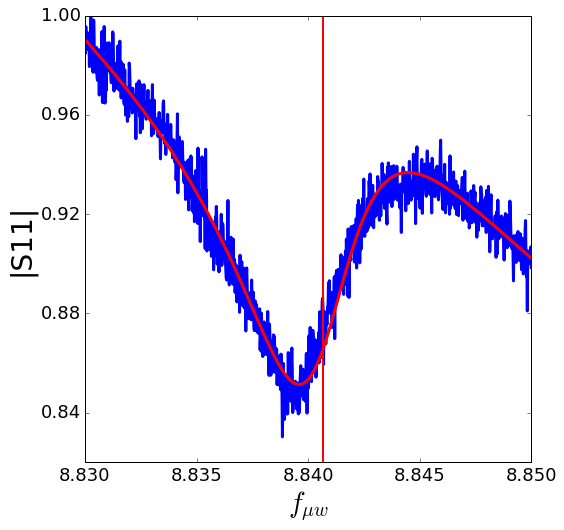

In [57]:
amp = np.absolute(_z_data_raw[15])
fig_amp, axes = plt.subplots(figsize = (8,8))
axes.plot(freq/10**9., amp**2./np.max(amp**2.), label = 'data', lw = 3.)
#axes.plot(freq, 20*np.log10(amp), label = 'data', lw = 2.)
axes.plot(freq/10**9., lorentz_sim/np.max(amp**2.),label = 'skewed lorentzian', color = 'red', lw = 3.)
axes.axvline(fr/10**9.,color = 'red', ls = '-', lw = 2.)
axes.set_xlabel(r'$f_{\mu w}$', fontsize = labelsize)
axes.set_ylabel(r'|S11|', fontsize = labelsize)
axes.set_xlim(8.83,8.85)
axes.set_yticks([0.84,0.88, 0.92, 0.96, 1.0])
#axes.set_title(str(title), fontsize = 20.)
#axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [58]:
'''circle fit routine for every power value'''
fres_cal = []
fres_pf = []
chi_sqr = []
Qloaded = []
Qload_pf = []
z_data_sim = []
for i in range(len(_power)):
    #powerspec._get_data_circle(norm = False)
    '''
    cf = rf_p(_freq, _z_data_raw[i])
    cf.set_Ql(1200)
    cf.set_theta0(0.1)
    #cf.autofit(coupling = 'overcoupled', ignoreslope = False, refine_res = True, plot = False)
    z_data_sim.append(cf.z_data_sim)
    fitresults = cf.fitresults
    fres_cal.append(fitresults['fr'])
    chi_sqr.append(fitresults['chi_square'])
    Qloaded.append(fitresults['Ql'])
    '''
    _fr, sign = cf._phase_fr_sign(_freq, np.unwrap(np.angle(_z_data_raw[i])),3, 20)
    theta0, Ql, fr = cf._phase_fit(_freq, _z_data_raw[i], 0.1, 1200, _fr, 1.)
    Qload_pf.append(Ql)
    fres_pf.append(fr)

fr (phase derivation) = 8841831424.0
fr (phase derivation) = 8841811968.0
fr (phase derivation) = 8841431040.0
fr (phase derivation) = 8841591808.0
fr (phase derivation) = 8841491456.0
fr (phase derivation) = 8841431040.0
fr (phase derivation) = 8841291776.0
fr (phase derivation) = 8841391104.0
fr (phase derivation) = 8841351168.0
fr (phase derivation) = 8841030656.0
fr (phase derivation) = 8840950784.0
fr (phase derivation) = 8841011200.0
fr (phase derivation) = 8840891392.0
fr (phase derivation) = 8839709696.0
fr (phase derivation) = 8839429120.0
fr (phase derivation) = 8839569408.0


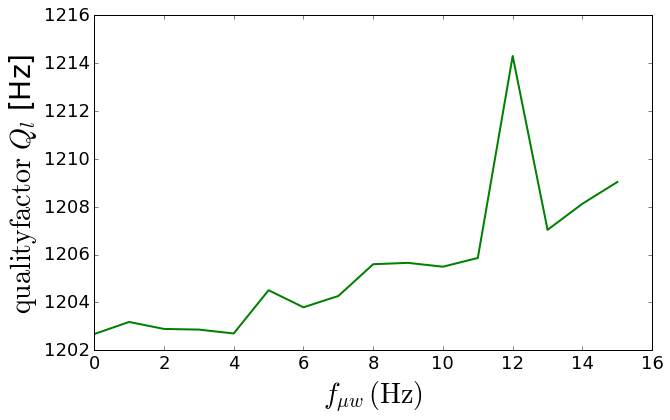

In [59]:
fig, axes = plt.subplots(figsize = (10,6))
#axes.plot(_power,Qloaded, label = r'$Q_L$ (circle fit)', lw = 2, color = 'blue')
axes.plot(_power,Qload_pf, label = r'$Q_L$ (phase fit)', lw = 2, color = 'green')
axes.set_ylabel(r'$\mathrm{quality factor}\,\,Q_l$ [Hz]', fontsize = labelsize)
axes.set_xlabel(r'$f_{\mu w}\,(\mathrm{Hz})$', fontsize= labelsize)

In [60]:
fres_cal = np.array(fres_cal)
mask = []
for i in range(len(fres_cal)):
    low = 8.8e9
    high = 9.e9
    mask.append(np.any((fres_cal[i] > high, fres_cal[i] < low), axis = 0))
fres_mask = np.ma.masked_array(fres_cal,mask)

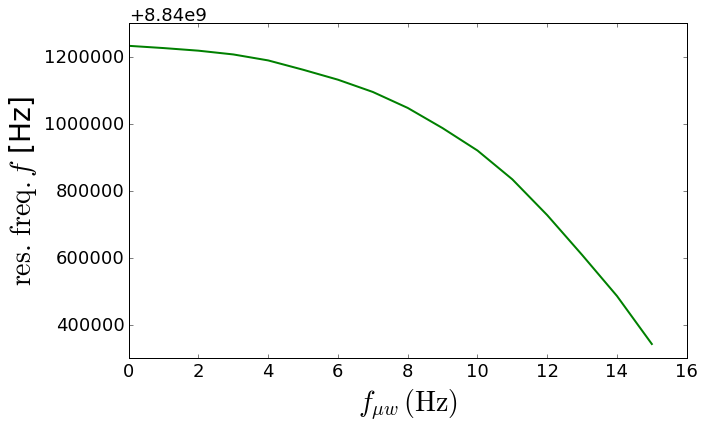

In [61]:
fig, axes = plt.subplots(figsize = (10,6))
#axes.plot(_power,fres_mask, label = 'fres (circle fit)', lw = 2, color = 'blue')
axes.plot(_power,fres_pf, label = 'fres (phase fit)', lw = 2, color = 'green')
axes.set_ylabel(r'$\mathrm{res.\,freq.} f$ [Hz]', fontsize = labelsize)
axes.set_xlabel(r'$f_{\mu w}\,(\mathrm{Hz})$', fontsize= labelsize)

In [62]:
cf = rf_p(_freq, _z_data_raw[i])
cf.autofit('overcoupled')

fr (phase derivation) = 8839510016.0
agebraic r0: 0.00145000022134
iterative r0: 0.00144923400286
zc = (-4.13944579319e-05-5.35958051294e-06j)
calibration: Theta0 0.361969575359
agebraic r0: 0.973236005753
iterative r0: 0.972721762965
-3.13511422568
phi_0 = 0.00647842790758


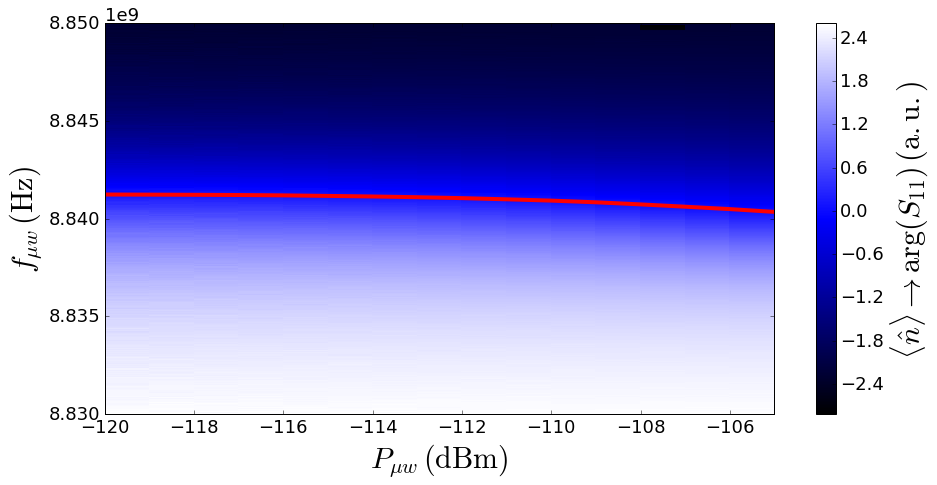

In [63]:
powerspec2.plot(powerspec2._power,_freq,powerspec2._phase.T, fres_pf)

In [64]:
powerspec2._fig.savefig('lowP_pspec_phase.pdf', dpi = 100, bbox_inches = 'tight' )

In [65]:
n_ph = cf.get_photons_in_resonator(powerspec2._power)

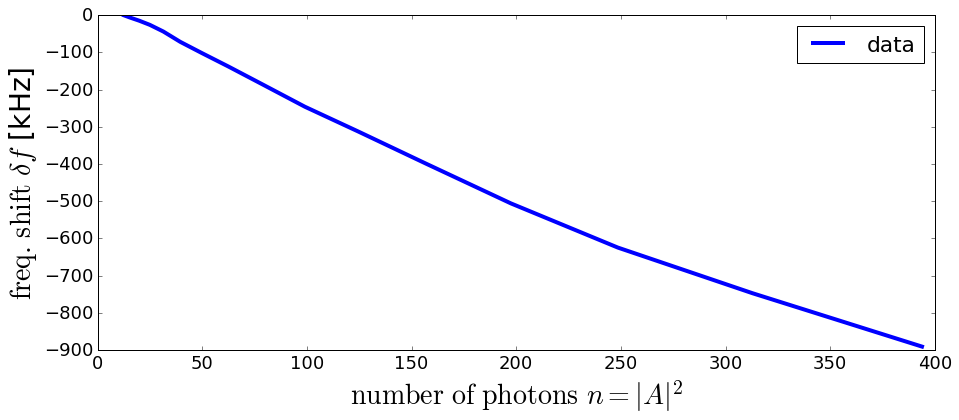

In [66]:
fig, axes = plt.subplots(figsize = (15,6))
#axes.plot(n_ph,(fres_mask-fres_mask[0])/1000, label = r'data', lw = 4)
axes.plot(n_ph,(fres_pf-fres_pf[0])/1000, label = r'data', lw = 4)


axes.set_ylabel(r'$\mathrm{freq.\,shift}\,\,\delta f$ [kHz]', fontsize = labelsize)
axes.set_xlabel(r'$\mathrm{number\,\,of\,\,photons}\,\,n = |A|^2 $', fontsize = labelsize)
axes.legend()

In [67]:
a, b, c, d = np.polyfit((n_ph-n_ph[0]),2*np.pi*(fres_pf-fres_pf[0]), 3)

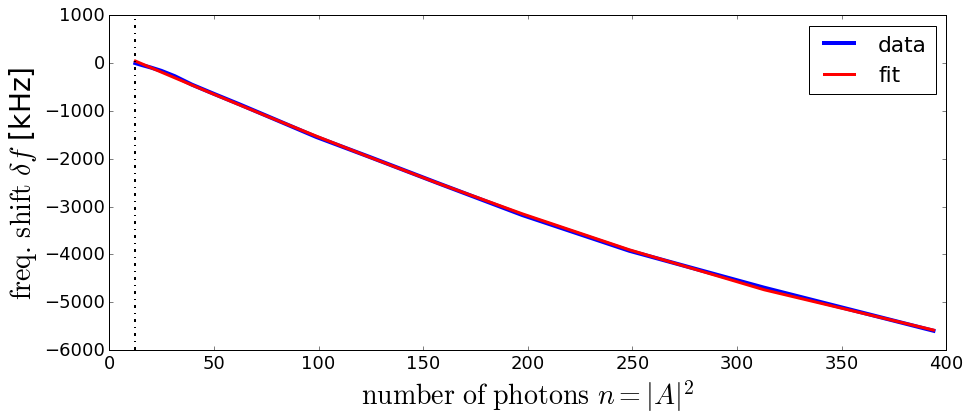

In [68]:
fig, axes = plt.subplots(figsize = (15,6))
axes.plot(n_ph,2*np.pi*(fres_pf-fres_pf[0])/1000, label = r'data', lw = 4)
axes.plot(n_ph, (a*(n_ph-n_ph[0])**3.+b*(n_ph-n_ph[0])**2.+c*(n_ph-n_ph[0])+d)/1000, label = r'fit', lw = 3, color = 'red')
#axes.axvline(n[0])
axes.set_ylabel(r'$\mathrm{freq.\,shift}\,\,\delta f$ [kHz]', fontsize = labelsize)
axes.set_xlabel(r'$\mathrm{number\,\,of\,\,photons}\,\,n = |A|^2 $', fontsize = labelsize)
#axes.set_xlim(0,1000)
#axes.set_ylim(-2000,0)
axes.axvline(n_ph[0], color = 'black', ls = '-.', lw = 2)
axes.legend()

In [69]:
print a, b, c, d

0.0132623037106 5.35263262013 -18719.1978132 42993.0603093


In [70]:
n_ph_high = cf.get_photons_in_resonator(powerspec2._power)

In [71]:
p_high = dBm2Watt(powerspec2._power)

In [72]:
#np.sqrt(p_high/50.)

In [73]:
#np.sqrt(n_ph_high*hbar*2.*np.pi*fres_pf[0]/50.)

### decay rates

In [74]:
Q_c = 1253

In [75]:
Qi_pf = 23000

In [76]:
deltaw = np.array(2.*np.pi*(fres_pf-fres_pf[0]))
kappa = 2.*np.pi*np.array(fres_pf)/np.array(Q_c)
gamma = 2.*np.pi*np.array(fres_pf)/np.array(Qi_pf)

In [77]:
kappa/10**6

array([ 44.33448211,  44.33444855,  44.33440945,  44.33435309,
        44.33426355,  44.33412411,  44.33397482,  44.3337912 ,
        44.33355215,  44.33324966,  44.33291419,  44.33248262,
        44.3319465 ,  44.33135085,  44.3307356 ,  44.33001612])

In [78]:
p  = dBm2Watt(powerspec2._power)

In [79]:
p

array([  1.00000000e-15,   1.25892654e-15,   1.58489245e-15,
         1.99526319e-15,   2.51188425e-15,   3.16227765e-15,
         3.98107518e-15,   5.01187023e-15,   6.30957595e-15,
         7.94327508e-15,   9.99999982e-15,   1.25892652e-14,
         1.58489250e-14,   1.99526319e-14,   2.51188434e-14,
         3.16227757e-14], dtype=float32)

In [80]:
alpha_1_sqr = []
for i in p:
    alpha_1_sqr.append(i/(hbar*2.*np.pi*fres_pf[0]))

In [81]:
alpha_1_sqr

[170699062.9428972,
 214897580.02478313,
 270539655.64712662,
 340589555.15352076,
 428776286.46422052,
 539797830.24456096,
 679565800.41733527,
 855521549.08718789,
 1077038698.7805262,
 1355909607.8626134,
 1706990593.2820396,
 2148975764.1008987,
 2705396628.765131,
 3405895551.5352073,
 4287763009.2299352,
 5397978157.8578796]

In [82]:
(kappa+gamma)**2

array([  2.18553890e+15,   2.18553559e+15,   2.18553174e+15,
         2.18552618e+15,   2.18551735e+15,   2.18550360e+15,
         2.18548888e+15,   2.18547078e+15,   2.18544721e+15,
         2.18541739e+15,   2.18538432e+15,   2.18534177e+15,
         2.18528891e+15,   2.18523019e+15,   2.18516954e+15,
         2.18509861e+15])

In [83]:
K = deltaw*(kappa+gamma)**2.*(1/4.+deltaw**2./(kappa+gamma)**2)/((alpha_1_sqr*kappa))

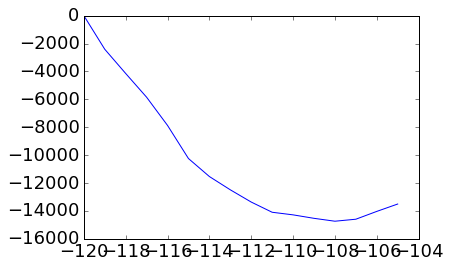

In [84]:
plt.plot(powerspec2._power,K)

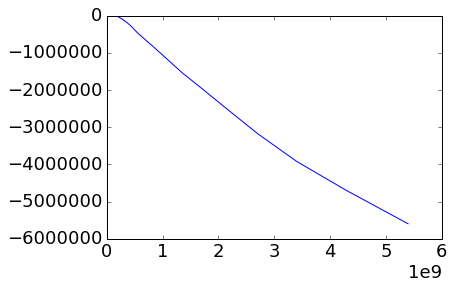

In [85]:
plt.plot(alpha_1_sqr, 2.*np.pi*(fres_pf-fres_pf[0]))

In [86]:
a, b = np.polyfit(alpha_1_sqr,2*np.pi*(fres_pf-fres_pf[0]), 1)

In [87]:
a

-0.0011234901937941597

### Kerr nonlinearity

In [88]:
alpha = a*(kappa[0]+gamma[0])**2./(4.*kappa[0])
print alpha

-13846.0595761


In [89]:
alpha/(2.*np.pi*fres_pf[0])

-2.4924903483914101e-07

In [90]:
p_crit = hbar*2.*np.pi*fres_pf[0]*(kappa+gamma)**3/(np.sqrt(27)*kappa*np.abs(alpha))

In [91]:
10*np.log10(p_crit/10**(-3))

array([-97.26643042, -97.26643699, -97.26644466, -97.2664557 ,
       -97.26647324, -97.26650056, -97.26652981, -97.26656578,
       -97.26661262, -97.26667188, -97.26673761, -97.26682216,
       -97.2669272 , -97.26704391, -97.26716446, -97.26730543])

In [92]:
alpha_0 = np.pi**2.*np.pi*fres_pf[0]*50/R_k

In [93]:
gamma_0 = (np.abs(2*np.pi*alpha)/alpha_0)**(1/3.)
print gamma_0

0.0547187642036


In [94]:
gamma_0eich = (-alpha*R_k*32./(np.pi**3.*2.*np.pi*fres_pf[0]*50.))**(1/3.)
print gamma_0eich

0.0510191275488


In [95]:
Phi_0 = phi_0/(2.*np.pi)

In [96]:
## calculated Kerr nonlinearity

In [97]:
def Kerr(L_J, w, C, gamma0):
    Phi_0 = phi_0/(2.*np.pi)
    EJ = Phi_0**2./(L_J)
    phi_zpf = np.sqrt(hbar/(2.*w*C))
    k_id = np.pi/(2.*(1.+gamma0))
    return -EJ*(phi_zpf/(Phi_0))**4.*np.cos(k_id)**4./(2.*hbar)

In [98]:
L_J2 = Phi_0/(0.7e-6)
print L_J2
print Phi_0**2./(L_J2)/h

4.70151393852e-10
3.4767846038e+11


In [99]:
L_J1 = Phi_0/(2.*6e-6)
print L_J1

2.74254979747e-11


In [100]:
print Phi_0**2./(L_J1)/h

5.96020217793e+12


In [101]:
print 3*L_J1

8.22764939241e-11


In [102]:
print Phi_0**2./(3.*L_J1)/h

1.98673405931e+12


In [103]:
K_cal = Kerr(3.*L_J1, 2.*np.pi*8.841e9, 600e-15, 0.045 )
K_cal2 = Kerr(L_J2, 2.*np.pi*8.841e9, 600e-15, 0.045 )

In [104]:
#Kerr nonlieanrity calculated
K_cal/(2.*np.pi*fres_pf[0])

-5.0028859296940466e-07

In [105]:
kappa

array([ 44334482.11156175,  44334448.54949743,  44334409.44616505,
        44334353.09115652,  44334263.55458768,  44334124.10500808,
        44333974.82130027,  44333791.19988099,  44333552.14723821,
        44333249.6573443 ,  44332914.18623453,  44332482.61685017,
        44331946.50248571,  44331350.85412832,  44330735.60489886,
        44330016.12137771])

### freq shift

In [106]:
deltaw_calc = alpha*np.array(alpha_1_sqr)*4.*kappa[0]/(kappa[0]+gamma[0])**2.

In [118]:
from matplotlib.lines import Line2D

In [123]:
markers = []
for m in Line2D.markers:
    try:
        if len(m) == 1 and m != ' ':
            markers.append(m)
    except TypeError:
        pass

In [128]:
markers[2]

u'|'

(-1.0, 0.1)

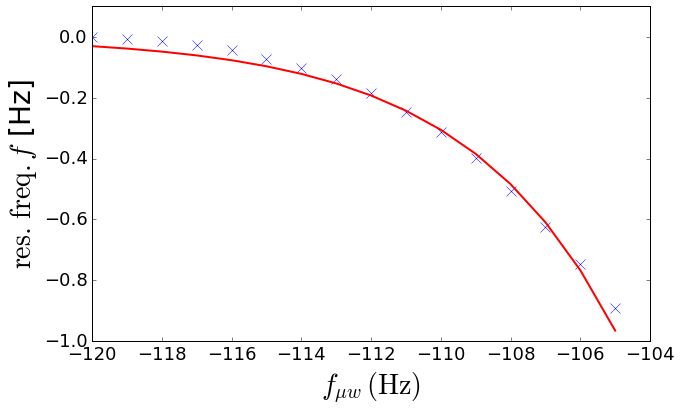

In [138]:
fig, axes = plt.subplots(figsize = (10,6))
#axes.plot(_power,fres_mask, label = 'fres (circle fit)', lw = 2, color = 'blue')
axes.plot(powerspec2._power,(fres_pf-fres_pf[0])/10**6., linestyle = 'None', marker=markers[3], markersize = 10, label = 'fres (phase fit)', lw = 2, color = 'blue')
axes.plot(powerspec2._power,deltaw_calc/(2.*np.pi)/10**6., label = 'fres (phase fit)', lw = 2, color = 'red')
axes.set_ylabel(r'$\mathrm{res.\,freq.} f$ [Hz]', fontsize = labelsize)
axes.set_xlabel(r'$f_{\mu w}\,(\mathrm{Hz})$', fontsize= labelsize)
axes.set_ylim(-1.0,0.1)

In [139]:
fig.savefig('JPA2_freq_shift.pdf', dpi = 400, bbox_to_anchor = 'tight')

# critcial frequency shift

In [114]:
def Delta_crit(kappa, gamma):
    return -np.sqrt(3.)*(kappa+gamma)/(4.*np.pi*10**6.)

In [115]:
Delta_crit(kappa[0],gamma[0])

-6.4436216755002178

In [177]:
#powerpath = "C:/Users/Patrick/Documents/JPA/Mask #3/data/20160407/120624_2D_VNA_tracedata/120624_2D_VNA_tracedata.h5"
#powerpath3 = "C:/Users/Patrick/Documents/JPA/Mask #3/data/20160407/115511_2D_VNA_tracedata/115511_2D_VNA_tracedata.h5"
powerpath3 = "C:/Users/Patrick/Documents/JPA/Mask #3/data/20160407/000814_2D_VNA_tracedata/000814_2D_VNA_tracedata.h5"

In [161]:
powerspec3 = ps(powerpath3, gaussfilter = False)
attenuation = 90
powerspec3._set_attenuation(attenuation)

no change - attenuation already: 0 dB


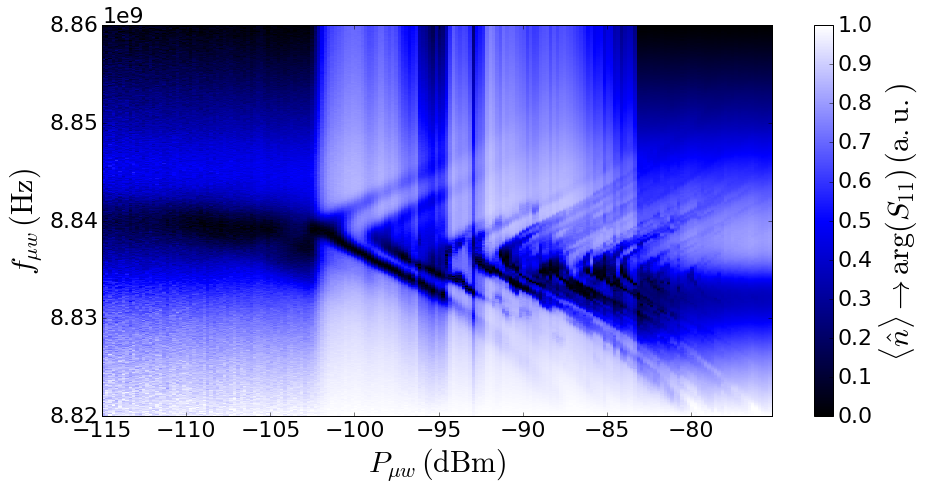

In [162]:
powerspec3._plot_amp(norm = True, save = False)

In [178]:
__data=hdf_lib.Data(path=powerpath3)
__freq = np.array(__data['/entry/data0/frequency'])
__amplitude = np.array(__data['/entry/data0/amplitude'])
__phase =  np.array(__data['/entry/data0/phase'])
__power = np.array(__data['/entry/data0/power (dbm)'])
__z_data_raw = __amplitude*np.exp(1.j*__phase)

In [239]:
__power[60]-90

-103.0

In [242]:
m = __cf._background(__freq, np.absolute(__z_data_raw[0])**2, 2)

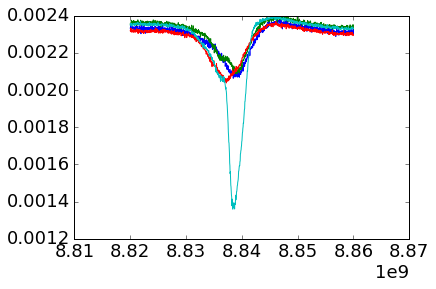

In [255]:
plt.plot(__freq, __amplitude[40]**2.-m*(__freq-fr))
plt.plot(__freq, __amplitude[50]**2.-m*(__freq-fr))
plt.plot(__freq, __amplitude[60]**2.-m*(__freq-fr))
plt.plot(__freq, __amplitude[68]**2.-m*(__freq-fr))

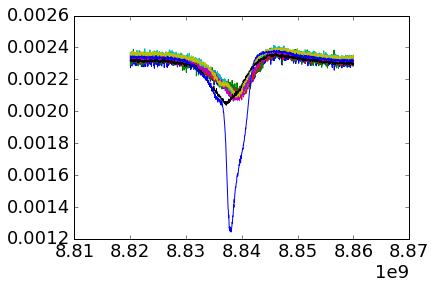

In [245]:
plt.plot(__freq, __amplitude[10]**2.-m*(__freq-fr))
plt.plot(__freq, __amplitude[0]**2.-m*(__freq-fr))
plt.plot(__freq, __amplitude[20]**2.-m*(__freq-fr))
plt.plot(__freq, __amplitude[30]**2.-m*(__freq-fr))
plt.plot(__freq, __amplitude[40]**2.-m*(__freq-fr))
plt.plot(__freq, __amplitude[50]**2.-m*(__freq-fr))
plt.plot(__freq, __amplitude[60]**2.-m*(__freq-fr))
plt.plot(__freq, __amplitude[70]**2.-m*(__freq-fr))

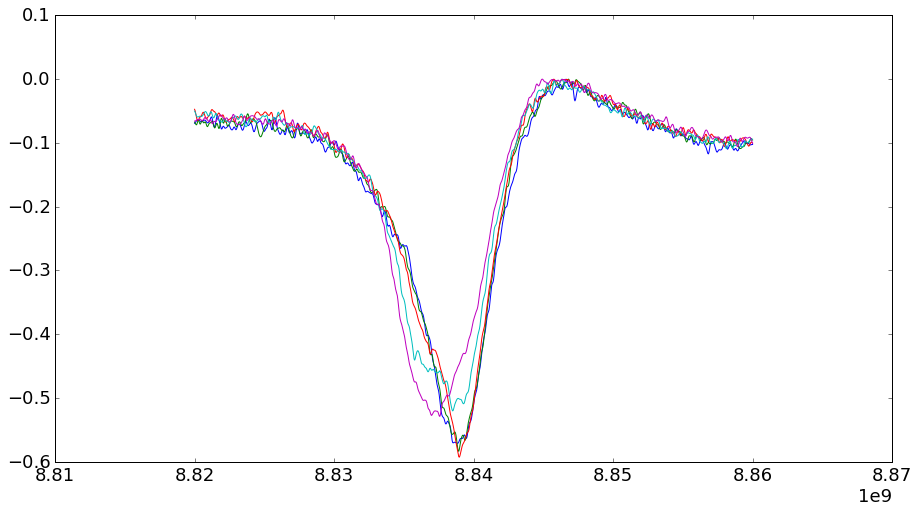

In [277]:
fig01 = plt.figure(figsize = (15,8))
for i in range(5):
    amp_sqred = gaussian_filter1d(__amplitude[40+4*i]**2.-m*(__freq-fr),2)
    plt.plot(__freq, 10.*np.log10(amp_sqred/np.max(amp_sqred)))

In [289]:
color = cm.rainbow(np.linspace(0,1,10))

In [304]:
plt.legend?

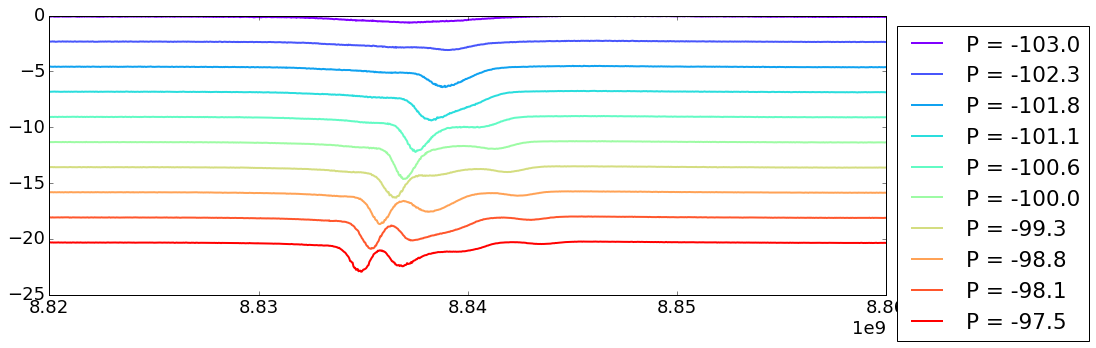

In [343]:
fig01 = plt.figure(figsize = (15,5))
for i in range(10):
    #amp_sqred = gaussian_filter1d(__amplitude[60+3*i]**2.-m*(__freq-fr),3)
    t = 60+3*i
    amp_sqred = __amplitude[t]**2.-m*(__freq-fr)
    plt.plot(__freq, 10.*np.log10(amp_sqred/np.max(amp_sqred))-2.25*i, label = 'P = {} dBm'.format(str(mt.ceil((__power[t]-90)*10)/10)), color = color[i], lw = 2)
plt.xlim(__freq[0], __freq[-1])
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

In [344]:
fig01.savefig('amp_row_-103to-97dBm.pdf', dpi = 100, bbox_inches = 'tight')

In [324]:
 plt.subplot?

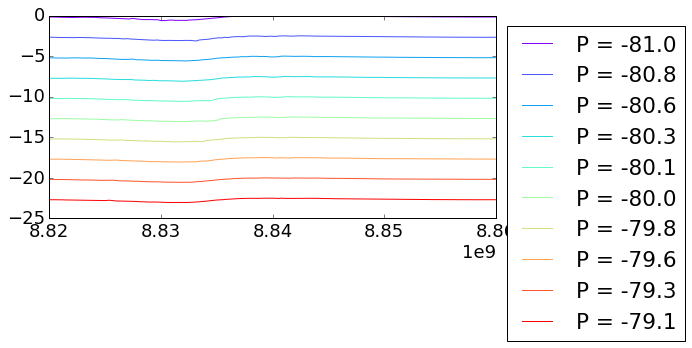

In [335]:
fig01 = plt.figure(figsize = (8,8))
subfig1 = plt.subplot(211)
for i in range(10):
    t = 170+1*i
    amp_sqred = gaussian_filter1d(__amplitude[t]**2.-m*(__freq-fr),0)
    subfig1.plot(__freq, 10.*np.log10(amp_sqred/np.max(amp_sqred))-2.5*i,label = 'P = {}'.format(str(mt.ceil((__power[t]-90)*10)/10)), color = color[i])
plt.xlim(__freq[0], __freq[-1])

plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

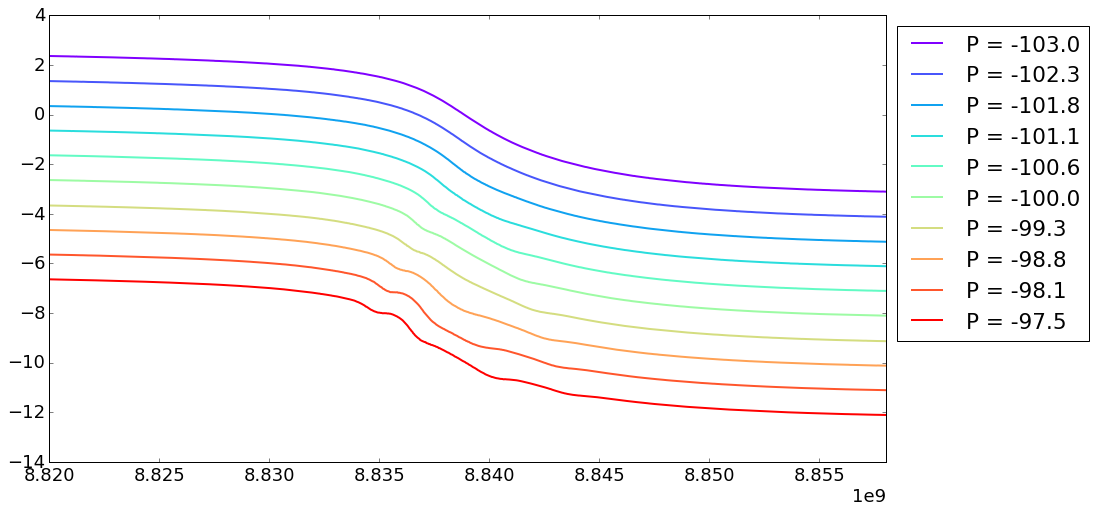

In [317]:
fig01 = plt.figure(figsize = (15,8))
for i in range(10):
    #amp_sqred = gaussian_filter1d(__amplitude[60+3*i]**2.-m*(__freq-fr),3)
    t = 60+3*i
    plt.plot(__freq, __phase[t]-i, label = 'P = {}'.format(str(mt.ceil((__power[t]-90)*10)/10)), color = color[i], lw = 2)
plt.xlim(__freq[0], __freq[-50])
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

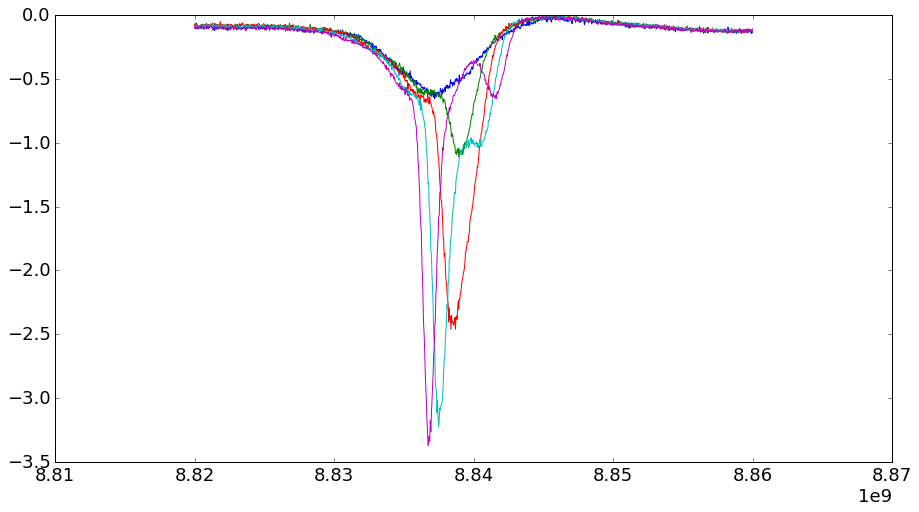

In [271]:
fig01 = plt.figure(figsize = (15,8))
for i in range(5):
    amp_sqred = __amplitude[60+4*i]**2.-m*(__freq-fr)
    plt.plot(__freq, 10.*np.log10(amp_sqred/np.max(amp_sqred)))

In [209]:
__cf = rf_p(__freq, __z_data_raw[0])
__cf2 = rf_p(__freq, __z_data_raw[199])

In [211]:
__fr2 = freq[np.argmin(gaussian_filter1d(__cf2._derivation(__freq, np.unwrap(__phase[199]), s = 0.1),6))]

In [212]:
__fr1, __sign = __cf._phase_fr_sign(__freq, np.unwrap(np.angle(__z_data_raw[0])), 3, 20)
__theta0 = __cf._theta0_start(__freq,np.unwrap(np.angle(__z_data_raw[0])), __fr1)
__theta0, __Ql, __fr = __cf._phase_fit(__freq, __z_data_raw[0], None, 1000, __fr1, 1, overcoupled = True)
  

fr (phase derivation) = 8841501696.0


In [213]:
__fr2, __sign = __cf._phase_fr_sign(__freq, np.unwrap(np.angle(__z_data_raw[199])), 3, 20)
__theta032 = __cf._theta0_start(__freq,np.unwrap(np.angle(__z_data_raw[199])), __fr2)
__theta032, __Ql32, __fr32 = __cf._phase_fit(__freq, __z_data_raw[199], -0.5, 1000, __fr2, 1, overcoupled = True)
  

fr (phase derivation) = 8833052672.0


In [214]:
print __fr
print __fr1
print __fr32
print __fr2

8841670338.62
8.8415e+09
8833616459.3
8.83305e+09


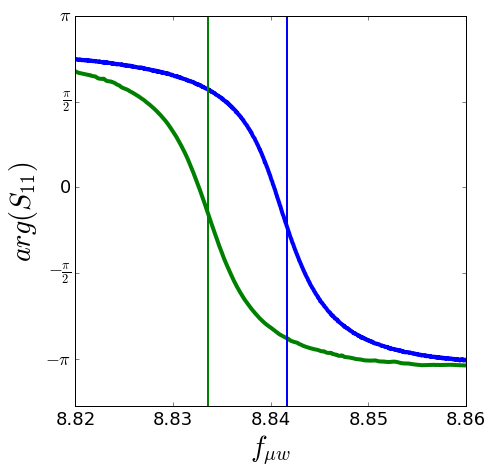

In [215]:
__phase31 = np.unwrap(np.angle(__z_data_raw[0]))
__phase32 = np.unwrap(np.angle(__z_data_raw[199]))
__phase_fit = __cf.phase_fitfunction(__freq, __theta0, __Ql, __fr, 0, 1., True )[0]
__phase_fit32 = __cf.phase_fitfunction(__freq, __theta032, __Ql32, __fr32, 0, 1., True )[0]
fig, axes = plt.subplots(figsize = (7,7))
axes.plot(__freq/10**9, __phase31, label = 'data', lw = 4.)
axes.plot(__freq/10**9, __phase32, label = 'data', lw = 4.)
#axes.plot(__freq/10**9., __phase_fit,label = 'phase fit w/ slope', color = 'red', lw = 2.)
#axes.plot(__freq/10**9., __phase_fit32,label = 'phase fit w/ slope', color = 'red', lw = 2.)
#axes.axvline(__fr/10**9., color = 'blue', ls = '-', lw = 2.)
axes.axvline(__fr/10**9., color = 'blue', ls = '-', lw = 2.)
axes.axvline(__fr32/10**9., color = 'green', ls = '-', lw = 2.)
axes.set_xlabel(r'$f_{\mu w}$', fontsize = labelsize)
axes.set_ylabel(r'$arg(S_{11})$', fontsize = labelsize)
axes.set_xlim(8.82,8.86)
axes.set_xticks([8.82,8.83,8.84,8.85,8.86])
plt.setp(axes, yticks=[-np.pi,-np.pi/2, 0., np.pi/2., np.pi], yticklabels = [r'$-\pi$',r'$-\frac{\pi}{2}$', '0',  r'$\frac{\pi}{2}$', r'$\pi$'])
#axes.set_title(str(title), fontsize = 20.)
#axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [216]:
fig.savefig('phase_mask3.pdf', dpi = 300, bbox_inches = 'tight')

In [217]:
__cf.autofit('overcoupled', ignoreslope = False)
__cf2.autofit('overcoupled', ignoreslope = False)

fr (phase derivation) = 8841421824.0
agebraic r0: 0.0498290759011
iterative r0: 0.0498186943654
zc = (-0.000942447499281-9.06462651324e-05j)
calibration: Theta0 -0.492574020462
agebraic r0: 0.935573576333
iterative r0: 0.935339647921
3.13009562612
phi_0 = -0.0114970274666
fr (phase derivation) = 8833133568.0
agebraic r0: 0.0509748325027
iterative r0: 0.0509507440606
zc = (-0.000516974692061-0.000214828941573j)
calibration: Theta0 -0.276739693041
agebraic r0: 0.969317212726
iterative r0: 0.968816618145
3.13451316757
phi_0 = -0.00707948602096


In [218]:
__cf.fitresults

{'Qc': 1222.1848715210654,
 'Qc_err': 17.764929980516104,
 'Qi': 17679.426892433676,
 'Qi_err': 5253.1293974172313,
 'Ql': 1143.15796742268,
 'Ql_err': 6.5083137616070204,
 'chi_square': 0.0041919820273450788,
 'fr': 8841436703.3580685,
 'fr_err': 25759.89051528243,
 'phi_0': -0.011497027466596792,
 'phi_0_err': 0.0054073906957059171,
 'theta0': -3.1457266447323762}

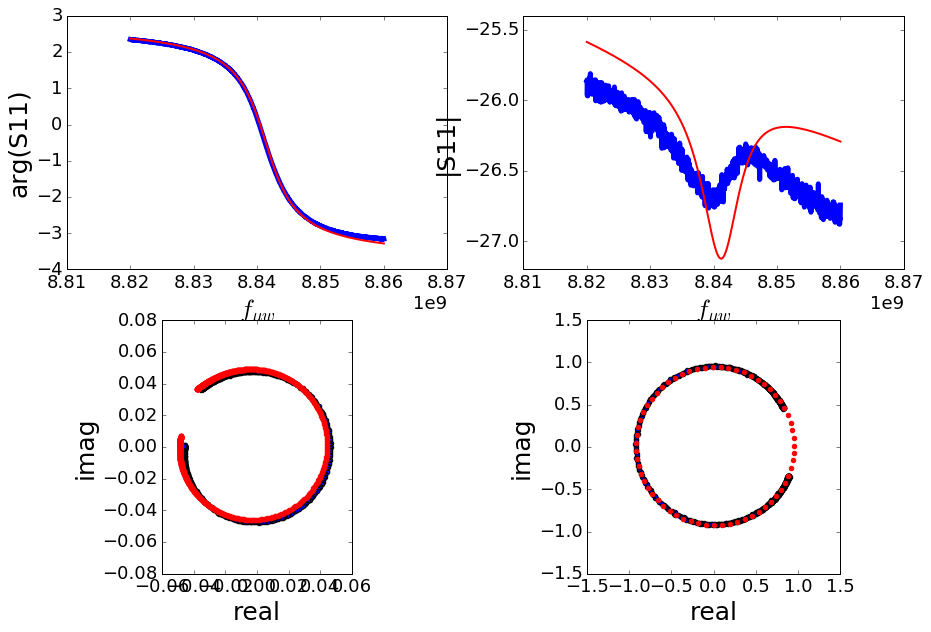

In [219]:
__cf.plot_all()

In [220]:
__cf2.fitresults

{'Qc': 934.3662259054405,
 'Qc_err': 33.656431999333968,
 'Qi': 29029.228814764567,
 'Qi_err': 45398.244751726488,
 'Ql': 905.2295270905023,
 'Ql_err': 12.713123604841456,
 'chi_square': 0.031643010235145097,
 'fr': 8832917829.8715115,
 'fr_err': 83496.430005146918,
 'phi_0': -0.0070794860209595868,
 'phi_0_err': 0.014909804075082798,
 'theta0': -3.1483323437390323}

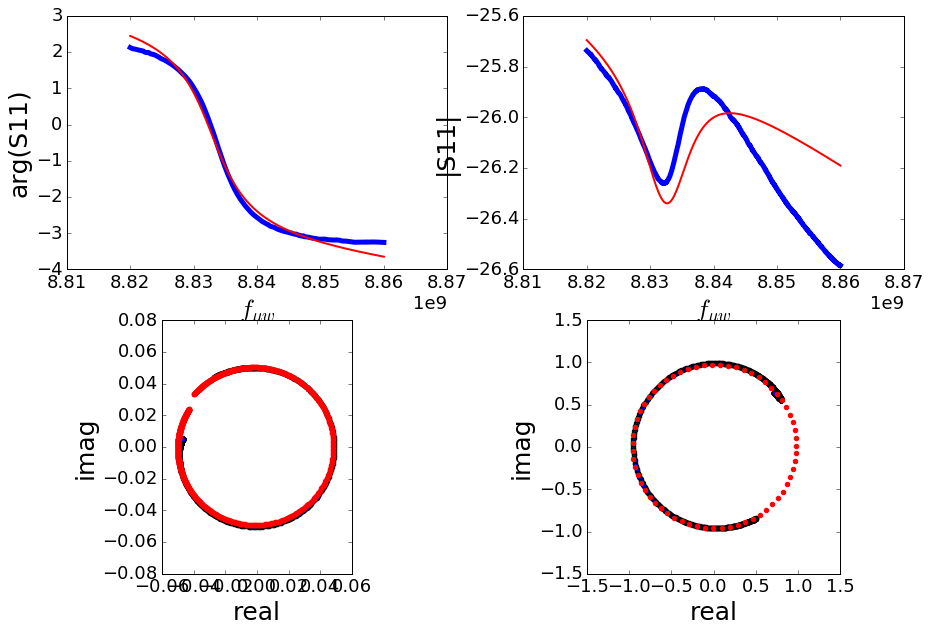

In [221]:
__cf2.plot_all()

In [222]:
print __cf.fitresults['fr']
print __cf2.fitresults['fr']

8841436703.36
8832917829.87


In [223]:
m = __cf._background(__freq, np.absolute(__z_data_raw[0])**2, 2)
m1 = __cf._background(__freq, np.absolute(__z_data_raw[199])**2, 2)

In [224]:
z0 = __cf.tilt_data(__freq, __z_data_raw[0], m)
z01 = __cf.tilt_data(__freq, __z_data_raw[199], m)

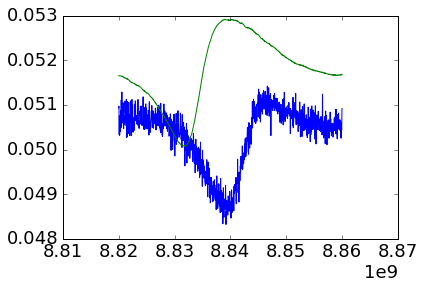

In [225]:
plt.plot(__freq, np.absolute(z0))
plt.plot(__freq, np.absolute(z01))

In [226]:
__A1, __A2, __A3, __A4, __fra, __Ql = __cf._fit_skewed_lorentzian(__freq, z0, ignoreslope = False)
__lorentz_sim = __cf.Lorentz_function(freq, __A1, __A2, __A3, __A4, __Ql, __fra)

In [227]:
__A11, __A21, __A31, __A41, __fra1, __Ql1 = __cf._fit_skewed_lorentzian(__freq, z01, ignoreslope = False)
__lorentz_sim1 = __cf.Lorentz_function(freq, __A11, __A21, __A31, __A41, __Ql1, __fra1)

In [228]:
print __A1, __A2, __A3, __A4, __fr, __Ql

0.00257060417117 -2.5462413377e-12 -0.000168098141083 5.46438562708e-11 8841670338.62 1342.39590368


(8.82, 8.86)

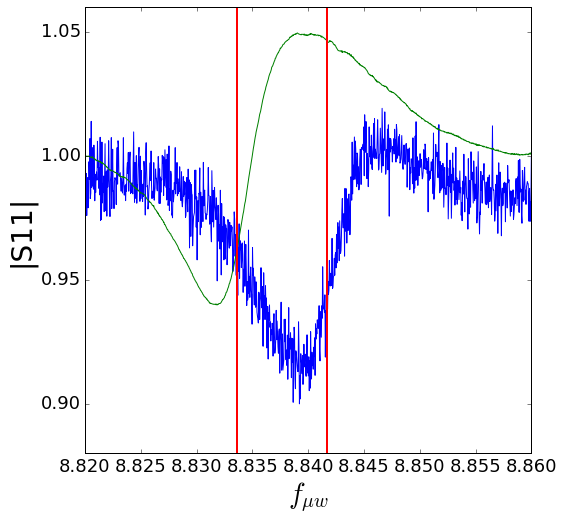

In [229]:
__amp = np.absolute(z0)
__amp32 = np.absolute(z01)
fig_amp, axes = plt.subplots(figsize = (8,8))
#axes.plot(__freq/10**9., __amp**2./np.max(__amp**2.), label = 'data', lw = 1.)
axes.plot(__freq/10**9., __amp**2./__amp[0]**2, label = 'data', lw = 1.)
axes.plot(__freq/10**9., __amp32**2./__amp32[0]**2, label = 'data', lw = 1.)
#axes.plot(freq, 20*np.log10(amp), label = 'data', lw = 2.)
#axes.plot(__freq/10**9., __lorentz_sim,label = 'skewed lorentzian', color = 'red', lw = 3.)
#axes.plot(__freq/10**9., __lorentz_sim1,label = 'skewed lorentzian', color = 'green', lw = 3.)
axes.axvline(__fr/10**9.,color = 'red', ls = '-', lw = 2.)
axes.axvline(__fr32/10**9.,color = 'red', ls = '-', lw = 2.)
axes.set_xlabel(r'$f_{\mu w}$', fontsize = labelsize)
axes.set_ylabel(r'|S11|', fontsize = labelsize)
axes.set_xlim(8.82,8.86)
#axes.set_yticks([0.84,0.88, 0.92, 0.96, 1.0])
#axes.set_title(str(title), fontsize = 20.)
#axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [349]:
x = np.linspace(0,6*np.pi, 500)

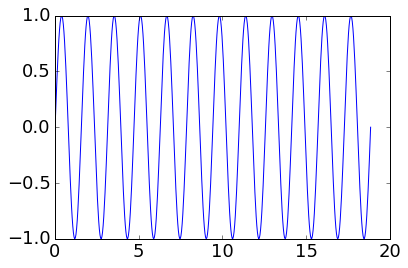

In [350]:
plt.plot(x, np.sin(4*x))

In [365]:
deltax = np.random.random_sample(100)/10

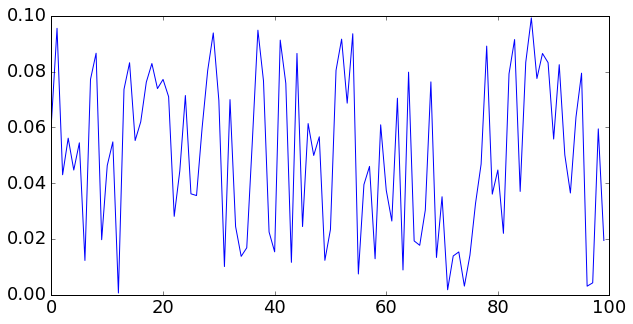

In [367]:
fig = plt.figure(figsize = (10,5))
plt.plot( deltax)

In [368]:
fig.savefig('noise_amp.pdf', dpi = 200, bbox_inches = 'tight')

In [363]:
plt.plot(x, np.sin(4*x)+deltax)

ValueError: operands could not be broadcast together with shapes (500,) (50,) 

In [ ]:
'''filepath:'''
stridat = "//pi-us28/patrick/Masks/Mask #2/JPA01/data/20151211/144213_1D2_VNA_tracedata/144213_1D2_VNA_tracedata.dat"

In [ ]:
ps_01 = ps(stridat, h5 = False)

In [ ]:
attenuation = 70